In [1]:
# Load libraries and instatiate DB connection

%matplotlib inline
import pandas as pd
import pymysql
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_seq_items = 2000

##### Reading data from db

In [2]:
# Connect to the database
connection = pymysql.connect(host='localhost', user='root', password='mprophet', db='movies')

# Pull table from database
cur = connection.cursor()


cur.execute("select * FROM bom")
bom_sql = []
for row in cur: bom_sql.append(list(row))

cur.execute("select movie_id,genre FROM omdb_movie_genre a join omdb_genres b on a.genre_id=b.genre_id")
omdb_genre_learning_data = []
for row in cur: omdb_genre_learning_data.append(list(row))

cur.execute("select a.key_bom,a.key_omdb,b.movie_id FROM movies_final a join omdb b on a.key_omdb=b.key_omdb")
omdb_bom_combine = []
for row in cur: omdb_bom_combine.append(list(row))

cur.close()
connection.close()

In [3]:
# Store bom table information in DataFrame

bom_columns =         ['bom_title', 'bom_link', 'key_bom', 'bom_date', 'bom_year', 'bom_name', 'bom_budget',
                       'bom_domestic_gross', 'bom_lifetime_gross', 'bom_release_date', 'bom_runtime', 'bom_distributor',
                       'bom_genre', 'bom_rating', 'bom_awards', 'bom_actor', 'bom_assoc_producer', 'bom_cinematographer',
                       'bom_composer', 'bom_director', 'bom_exec_producer', 'bom_line_producer', 'bom_players', 'bom_producer',
                       'bom_writer', 'bom_close_date', 'bom_domestic_summary', 'bom_in_release', 'bom_limited_opening_weekend',
                       'bom_opening_weekend', 'bom_wide_opening_weekend', 'bom_widest_release', 'bom_domestic_revenue',
                       'bom_foreign_revenue', 'bom_worldwide_revenue', 'bom_total_lifetime_gross']

bom = pd.DataFrame(bom_sql, columns=bom_columns)
#bom.to_csv('bom.csv')
print('Total movies from Box Office Mojo:', len(bom))
bom.head(1)

Total movies from Box Office Mojo: 16826


,bom_title,bom_link,key_bom,bom_date,bom_year,bom_name,bom_budget,bom_domestic_gross,bom_lifetime_gross,bom_release_date,bom_runtime,bom_distributor,bom_genre,bom_rating,bom_awards,bom_actor,bom_assoc_producer,bom_cinematographer,bom_composer,bom_director,bom_exec_producer,bom_line_producer,bom_players,bom_producer,bom_writer,bom_close_date,bom_domestic_summary,bom_in_release,bom_limited_opening_weekend,bom_opening_weekend,bom_wide_opening_weekend,bom_widest_release,bom_domestic_revenue,bom_foreign_revenue,bom_worldwide_revenue,bom_total_lifetime_gross
0,#horror,http://www.boxofficemojo.com/movies/?id=horrorifc.htm,b0,20-Nov-15,2015\r,#Horror,N/A,,,20-Nov-15,1 hrs. 30 min.,IFC,Horror,Unknown,No Academy Awards Information\r,"""['Balthazar Getty', 'Timothy Hutton', 'Natasha Lyonne', 'Taryn Manning', 'Chloe Sevigny']""",,,,,,,,,\r,,No Domestic Summary Information,,,,,\r,,,,No Total Lifetime Gross Information\r


###### Filtering for movies with budgter and gross

In [4]:
print("no:of movies in bom where budget and bom_worldwide_revenue is not null:")
g = bom.bom_worldwide_revenue
print(bom[(bom.bom_budget!="") & (bom.bom_budget!="N/A") & (g!="")].shape)

bom_f = bom[(bom.bom_budget!="") & (bom.bom_budget!="N/A") & (g!="")]
bom_f= bom_f[["key_bom","bom_title","bom_budget","bom_worldwide_revenue"]]
print("Bom movies with budget/gross (worldwide) info: ", bom_f.shape)

no:of movies in bom where budget and bom_worldwide_revenue is not null:
(2530, 36)
Bom movies with budget/gross (worldwide) info:  (2530, 4)


###### Cleaning budget, gross column

In [5]:
bom_f.reset_index(inplace=True,drop=True)
movie_df = bom_f
# Cleaning bom budget and revenue
movie_df.loc[movie_df.bom_budget == "",'bom_budget']= movie_df.loc[movie_df.bom_budget=="",'bom_budget'].apply(lambda x: float(x.replace('', '0.0')))
movie_df.loc[movie_df.bom_worldwide_revenue == "",'bom_worldwide_revenue'] = movie_df.loc[movie_df.bom_worldwide_revenue=="",'bom_worldwide_revenue'].apply(lambda x: float(x.replace('', '0.0')))

import warnings
warnings.filterwarnings('ignore')

movie_df['bom_budget'] = movie_df['bom_budget'].str.replace('$','')
movie_df['bom_budget'] = movie_df['bom_budget'].str.replace('"','')
movie_df['bom_budget'] = movie_df['bom_budget'].str.replace(',','')

for r in range(0,movie_df.shape[0]):
    s = str(movie_df.loc[r,'bom_budget'])
    if("million" in s):
        movie_df.loc[r,'bom_budget'] = movie_df.loc[r,'bom_budget'].replace("million","")
        movie_df.loc[r,'bom_budget'] = float(movie_df.loc[r,'bom_budget'])*1000000
    else:
        movie_df.loc[r,'bom_budget'] = float(movie_df.loc[r,'bom_budget'])
movie_df['bom_worldwide_revenue'] = movie_df['bom_worldwide_revenue'].str.replace('$','')
movie_df['bom_worldwide_revenue'] = movie_df['bom_worldwide_revenue'].str.replace('"','')
movie_df['bom_worldwide_revenue'] = movie_df['bom_worldwide_revenue'].str.replace(',','')
movie_df['bom_worldwide_revenue'] = movie_df['bom_worldwide_revenue'].str.replace('n/a','')

movie_df.loc[movie_df.bom_worldwide_revenue == "",'bom_worldwide_revenue'] = movie_df.loc[movie_df.bom_worldwide_revenue=="",'bom_worldwide_revenue'].apply(lambda x: float(x.replace('', '0.0')))


for r in range(0,movie_df.shape[0]):
    #print(movie_df.loc[r,'bom_worldwide_revenue'])
    movie_df.loc[r,'bom_worldwide_revenue'] = float(movie_df.loc[r,'bom_worldwide_revenue'])

In [6]:
movie_df.head(2)

,key_bom,bom_title,bom_budget,bom_worldwide_revenue
0,b10,(500) days of summer,7.5e+06,6.07227e+07
1,b24,10 things i hate about you,3e+07,5.34782e+07


In [7]:
print(movie_df.shape)
movie_df = movie_df[(movie_df['bom_budget']!=0.0)&(movie_df['bom_worldwide_revenue']!=0.0)]
movie_df.reset_index(inplace=True,drop=True)
print(movie_df.shape)

(2530, 4)
(2527, 4)


###### Filtering budget, gross > 10,000

In [8]:
movie_df = movie_df[(movie_df['bom_budget']>10000) & (movie_df['bom_worldwide_revenue']>10000)]
movie_df.reset_index(inplace=True,drop=True)
print(movie_df.shape)

(2520, 4)


In [9]:
movie_df['revenue'] = (movie_df['bom_worldwide_revenue'] - movie_df['bom_budget']) / movie_df['bom_budget']
movie_df.head(2)

,key_bom,bom_title,bom_budget,bom_worldwide_revenue,revenue
0,b10,(500) days of summer,7.5e+06,6.07227e+07,7.09636
1,b24,10 things i hate about you,3e+07,5.34782e+07,0.782606


In [10]:
movie_df[movie_df['revenue']<1].shape

(1100, 5)

In [11]:
movie_df.to_csv("bom_1.csv",index=None)

In [12]:
movie_df[movie_df['revenue']>10].shape

(147, 5)

##### Filtering revenue < 10

In [13]:
movie_df = movie_df[movie_df['revenue']<10]
movie_df.reset_index(inplace=True,drop=True)
movie_df.shape

(2373, 5)

###### Features related to release date

In [14]:
movie_df = movie_df.merge(bom[['bom_release_date',"key_bom"]],on="key_bom",how="left",)
movie_df.shape

(2373, 6)

In [15]:
movie_df.head()

,key_bom,bom_title,bom_budget,bom_worldwide_revenue,revenue,bom_release_date
0,b10,(500) days of summer,7.5e+06,6.07227e+07,7.09636,17-Jul-09
1,b24,10 things i hate about you,3e+07,5.34782e+07,0.782606,31-Mar-99
2,b27,"""10,000 b.c.""",1.05e+08,2.69784e+08,1.56937,7-Mar-08
3,b38,102 dalmatians,8.5e+07,1.83612e+08,1.16014,22-Nov-00
4,b39,10th &amp; wolf,8e+06,143451,-0.982069,18-Aug-06


In [16]:
import datetime as dt

for r in range(0,movie_df.shape[0]):
    if(len(movie_df.loc[r,'bom_release_date'])>=8):   
        movie_df.loc[r,'bom_release_date'] = pd.to_datetime(movie_df.loc[r,'bom_release_date'], format='%d-%b-%y')
    else:
        movie_df.loc[r,'bom_release_date'] = ""

movie_df.head()

,key_bom,bom_title,bom_budget,bom_worldwide_revenue,revenue,bom_release_date
0,b10,(500) days of summer,7.5e+06,6.07227e+07,7.09636,2009-07-17 00:00:00
1,b24,10 things i hate about you,3e+07,5.34782e+07,0.782606,1999-03-31 00:00:00
2,b27,"""10,000 b.c.""",1.05e+08,2.69784e+08,1.56937,2008-03-07 00:00:00
3,b38,102 dalmatians,8.5e+07,1.83612e+08,1.16014,2000-11-22 00:00:00
4,b39,10th &amp; wolf,8e+06,143451,-0.982069,2006-08-18 00:00:00


In [17]:
movie_df_3 = movie_df
# Get the month as a feature
from datetime import datetime 
for r in range(0,movie_df_3.shape[0]):
    if(movie_df_3.loc[r,'bom_release_date']!=""):
        movie_df_3.loc[r,'release_month'] = datetime.strftime(movie_df_3.loc[r,'bom_release_date'],"%m")
    else:
        movie_df_3.loc[r,'release_month'] = ""
        
# Get the quarter
for r in range(0,movie_df_3.shape[0]):
    if(movie_df_3.loc[r,'bom_release_date']!=""):
        movie_df_3.loc[r,'release_quarter'] = movie_df_3.loc[r,'bom_release_date'].quarter
    else:
        movie_df_3.loc[r,'release_quarter'] = ""
        
# Get the day of the year
for r in range(0,movie_df_3.shape[0]):
    if(movie_df_3.loc[r,'bom_release_date']!=""):
        movie_df_3.loc[r,'release_day_of_the_year'] = datetime.strftime(movie_df_3.loc[r,'bom_release_date'],"%j").lstrip("0")
    else:
        movie_df_3.loc[r,'release_day_of_the_year'] = ""

# get the week of the year
for r in range(0,movie_df_3.shape[0]):
    if(movie_df_3.loc[r,'bom_release_date']!=""):
        movie_df_3.loc[r,'release_week_of_the_year'] = datetime.strftime(movie_df_3.loc[r,'bom_release_date'],"%U").lstrip("0")
    else:
        movie_df_3.loc[r,'release_week_of_the_year'] = ""

# get the year
for r in range(0,movie_df_3.shape[0]):
    if(movie_df_3.loc[r,'bom_release_date']!=""):
        movie_df_3.loc[r,'release_year'] = datetime.strftime(movie_df_3.loc[r,'bom_release_date'],"%Y")
    else:
        movie_df_3.loc[r,'release_year'] = ""


movie_df = movie_df_3
print(movie_df.shape)
movie_df.head()

(2373, 11)


,key_bom,bom_title,bom_budget,bom_worldwide_revenue,revenue,bom_release_date,release_month,release_quarter,release_day_of_the_year,release_week_of_the_year,release_year
0,b10,(500) days of summer,7.5e+06,6.07227e+07,7.09636,2009-07-17 00:00:00,07,3,198,28,2009
1,b24,10 things i hate about you,3e+07,5.34782e+07,0.782606,1999-03-31 00:00:00,03,1,90,13,1999
2,b27,"""10,000 b.c.""",1.05e+08,2.69784e+08,1.56937,2008-03-07 00:00:00,03,1,67,9,2008
3,b38,102 dalmatians,8.5e+07,1.83612e+08,1.16014,2000-11-22 00:00:00,11,4,327,47,2000
4,b39,10th &amp; wolf,8e+06,143451,-0.982069,2006-08-18 00:00:00,08,3,230,33,2006


##### Runtime

In [18]:
movie_df = movie_df.merge(bom[['bom_runtime',"key_bom"]],on="key_bom",how="left")
movie_df.shape

(2373, 12)

In [19]:
movie_df['bom_runtime'] = [str(v).lstrip() for v in movie_df['bom_runtime']]
movie_df['bom_runtime']= [str(v).rstrip() for v in movie_df['bom_runtime']]
movie_df['bom_runtime']= [v.replace('N/A',"") for v in movie_df['bom_runtime']]

for r in range(0,movie_df.shape[0]):
    if(movie_df.loc[r,'bom_runtime']!=""):
        a = movie_df.loc[r,'bom_runtime'].replace(" ","")
        a = a.split('hrs.')
        if (len(a)>1):
            m = a[1].split('min.')[0]
        else:
            m = 0
        movie_df.loc[r,'runtime'] = float(a[0])*60+float(m)
    else:
        movie_df.loc[r,'runtime'] = ""

In [20]:
movie_df.head()

,key_bom,bom_title,bom_budget,bom_worldwide_revenue,revenue,bom_release_date,release_month,release_quarter,release_day_of_the_year,release_week_of_the_year,release_year,bom_runtime,runtime
0,b10,(500) days of summer,7.5e+06,6.07227e+07,7.09636,2009-07-17 00:00:00,07,3,198,28,2009,1 hrs. 35 min.,95
1,b24,10 things i hate about you,3e+07,5.34782e+07,0.782606,1999-03-31 00:00:00,03,1,90,13,1999,1 hrs. 37 min.,97
2,b27,"""10,000 b.c.""",1.05e+08,2.69784e+08,1.56937,2008-03-07 00:00:00,03,1,67,9,2008,1 hrs. 49 min.,109
3,b38,102 dalmatians,8.5e+07,1.83612e+08,1.16014,2000-11-22 00:00:00,11,4,327,47,2000,1 hrs. 44 min.,104
4,b39,10th &amp; wolf,8e+06,143451,-0.982069,2006-08-18 00:00:00,08,3,230,33,2006,1 hrs. 50 min.,110


In [21]:
movie_df.shape

(2373, 13)

In [22]:
movie_df.to_csv("bom_2.csv",index=None)

###### Awards

In [23]:
# Create a score for awards and add it to the table
award_win_factor = 5
bom_awa = bom[~bom['bom_awards'].str.contains('No Academy Awards Information')][['key_bom','bom_awards']].copy()
bom_awa['bom_awards_num'] = bom_awa['bom_awards'].str.replace('\r','')
bom_awa['bom_awards_num'] = bom_awa['bom_awards_num'].str.replace('Nominated for ','')
bom_awa['bom_awards_num'] = bom_awa['bom_awards_num'].str.replace(' Oscars','')
bom_awa['bom_awards_num'] = bom_awa['bom_awards_num'].str.replace(' Oscar','')
bom_awa['bom_awards_num'] = bom_awa['bom_awards_num'].str.replace(', Including','')
bom_awa['bom_awards_num'] = bom_awa['bom_awards_num'].str.replace(' Win.','')
bom_awa['bom_awards_num'] = bom_awa['bom_awards_num'].str.replace('.','')
bom_awa['bom_awards_num'] = bom_awa['bom_awards_num'].str.replace('"','')

alpha_to_num = {'One':1, 'Two':2, 'Three':3, 'Four':4, 'Five':5, 'Six':6, 'Seven':7, 'Eight':8, 'Nine':9, 
                'Ten':10, 'Eleven':11, 'Twelve':12, 'Thirteen':13, 'Fourteen':14}
bom_awa['bom_awards_num'] = bom_awa['bom_awards_num'].apply(lambda x: x.split(' '))
bom_awa['bom_awards_num'] = bom_awa['bom_awards_num'].apply(lambda x: [alpha_to_num[val] for val in x ])
bom_awa['bom_awards_scr'] = bom_awa['bom_awards_num'].apply(lambda x: x[0]+x[1]*award_win_factor if len(x)>1 else x[0] )

movie_df = pd.merge(movie_df,bom_awa[['key_bom', 'bom_awards', 'bom_awards_scr']],on = "key_bom",how="left")
movie_df['bom_awards_scr'].fillna(0, inplace=True)

print('Shape of finalized table', movie_df.shape)
movie_df.head(3)

Shape of finalized table (2373, 15)


,key_bom,bom_title,bom_budget,bom_worldwide_revenue,revenue,bom_release_date,release_month,release_quarter,release_day_of_the_year,release_week_of_the_year,release_year,bom_runtime,runtime,bom_awards,bom_awards_scr
0,b10,(500) days of summer,7.5e+06,6.07227e+07,7.09636,2009-07-17 00:00:00,07,3,198,28,2009,1 hrs. 35 min.,95,NaN,0
1,b24,10 things i hate about you,3e+07,5.34782e+07,0.782606,1999-03-31 00:00:00,03,1,90,13,1999,1 hrs. 37 min.,97,NaN,0
2,b27,"""10,000 b.c.""",1.05e+08,2.69784e+08,1.56937,2008-03-07 00:00:00,03,1,67,9,2008,1 hrs. 49 min.,109,NaN,0


In [24]:
movie_df[movie_df['bom_awards'].isnull()].shape

(1927, 15)

In [25]:
movie_df[~movie_df['bom_awards'].isnull()].head()

,key_bom,bom_title,bom_budget,bom_worldwide_revenue,revenue,bom_release_date,release_month,release_quarter,release_day_of_the_year,release_week_of_the_year,release_year,bom_runtime,runtime,bom_awards,bom_awards_scr
3,b38,102 dalmatians,8.5e+07,1.83612e+08,1.16014,2000-11-22 00:00:00,11,4,327,47,2000,1 hrs. 44 min.,104,Nominated for One Oscar.\r,1
5,b48,12 years a slave,2e+07,1.87733e+08,8.38666,2013-10-18 00:00:00,10,4,291,41,2013,2 hrs. 13 min.,133,"""Nominated for Nine Oscars, Including Three Wins.""\r",24
6,b50,127 hours,1.8e+07,6.07388e+07,2.37438,2010-11-05 00:00:00,11,4,309,44,2010,1 hrs. 33 min.,93,Nominated for Six Oscars.\r,6
8,b55,13 hours: the secret soldiers of benghazi,5e+07,6.94114e+07,0.388227,2016-01-15 00:00:00,01,1,15,2,2016,2 hrs. 24 min.,144,Nominated for One Oscar.\r,1
11,b80,1941,3.5e+07,9.24557e+07,1.64159,1979-12-14 00:00:00,12,4,348,49,1979,1 hrs. 58 min.,118,Nominated for Three Oscars.\r,3


###### Holiday season

In [26]:
from pandas.tseries.holiday import USFederalHolidayCalendar
import datetime
from datetime import timedelta

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='1900-01-01', end='2017-12-31').to_pydatetime()

holidays_new = list(holidays)
print(len(holidays_new))

for h in holidays:
    holidays_new.append(h + datetime.timedelta(days=7))
    holidays_new.append(h + datetime.timedelta(days=6))
    holidays_new.append(h + datetime.timedelta(days=5))
    holidays_new.append(h + datetime.timedelta(days=4))
    holidays_new.append(h + datetime.timedelta(days=3))
    holidays_new.append(h + datetime.timedelta(days=2))
    holidays_new.append(h + datetime.timedelta(days=1))
    
    holidays_new.append(h - datetime.timedelta(days=7))
    holidays_new.append(h - datetime.timedelta(days=6))
    holidays_new.append(h - datetime.timedelta(days=5))
    holidays_new.append(h - datetime.timedelta(days=4))
    holidays_new.append(h - datetime.timedelta(days=3))
    holidays_new.append(h - datetime.timedelta(days=2))
    holidays_new.append(h - datetime.timedelta(days=1))
    
print(len(holidays_new))

1094
16410


In [27]:
movie_df = movie_df.fillna("")

for r in range(0,movie_df.shape[0]):
    if(movie_df.loc[r,'bom_release_date']!=""):
        if movie_df.loc[r,'bom_release_date'] in holidays_new:
            movie_df.loc[r,'holiday_season'] = 1
        else:
            movie_df.loc[r,'holiday_season'] = 0
    else:
        movie_df.loc[r,'holiday_season'] = ""
        
print(movie_df.shape)
movie_df.head(3)

(2373, 16)


,key_bom,bom_title,bom_budget,bom_worldwide_revenue,revenue,bom_release_date,release_month,release_quarter,release_day_of_the_year,release_week_of_the_year,release_year,bom_runtime,runtime,bom_awards,bom_awards_scr,holiday_season
0,b10,(500) days of summer,7500000,60722734,7.096365,2009-07-17 00:00:00,07,3,198,28,2009,1 hrs. 35 min.,95,,0,0
1,b24,10 things i hate about you,30000000,53478166,0.782606,1999-03-31 00:00:00,03,1,90,13,1999,1 hrs. 37 min.,97,,0,0
2,b27,"""10,000 b.c.""",105000000,269784201,1.569373,2008-03-07 00:00:00,03,1,67,9,2008,1 hrs. 49 min.,109,,0,0


##### MPAA rating

Categories 1 to 7 as listed below

* G
* PG/M/GP
* PG-13
* R
* NC-17/X
* Unrated/Not Rated/ Not Yet rated
* Unknown

In [28]:
bom['bom_rating'] = [v.upper() for k,v in bom['bom_rating'].iteritems()]
print("No: of unique rating from bom",bom['bom_rating'].unique().shape)
bom['bom_rating'].unique().tolist()

No: of unique rating from bom (12,)


['UNKNOWN',
 'R',
 'UNRATED',
 'PG-13',
 'PG',
 'NOT YET RATED',
 'G',
 'NC-17',
 'M',
 'GP',
 'M/PG',
 'X']

In [29]:
# Merging the movies_df to bom omdb to fetch MPAA rating
print(movie_df.shape)
movie_df = movie_df.fillna("")
movie_df = pd.merge(movie_df,bom[["key_bom","bom_rating"]],on="key_bom",how="left")
print(movie_df.shape)

(2373, 16)
(2373, 17)


In [30]:
for r in range(0,movie_df.shape[0]):
    if(movie_df.loc[r,'bom_rating']=="G"):
        movie_df.loc[r,'mpaa_rating'] = 1
    elif(movie_df.loc[r,'bom_rating']=="PG" or movie_df.loc[r,'bom_rating']=="M" or movie_df.loc[r,'bom_rating']=="GP"):
        movie_df.loc[r,'mpaa_rating'] = 2
    elif(movie_df.loc[r,'bom_rating']=="PG-13"):
        movie_df.loc[r,'mpaa_rating'] = 3
    elif(movie_df.loc[r,'bom_rating']=="R"):
        movie_df.loc[r,'mpaa_rating'] = 4
    elif(movie_df.loc[r,'bom_rating']=="NC-17" or movie_df.loc[r,'bom_rating']=="X"):
        movie_df.loc[r,'bom_rating'] = 5
    elif(movie_df.loc[r,'bom_rating']=="UNRATED" or movie_df.loc[r,'bom_rating']=="NOT RATED" or movie_df.loc[r,'bom_rating']=="NOT YET RATED"):
        movie_df.loc[r,'mpaa_rating'] = 6
    else:
        movie_df.loc[r,'mpaa_rating'] = 7

movie_df['mpaa_rating'] = movie_df['mpaa_rating'].astype(object)
print(movie_df.shape)
movie_df.head(3)

(2373, 18)


,key_bom,bom_title,bom_budget,bom_worldwide_revenue,revenue,bom_release_date,release_month,release_quarter,release_day_of_the_year,release_week_of_the_year,release_year,bom_runtime,runtime,bom_awards,bom_awards_scr,holiday_season,bom_rating,mpaa_rating
0,b10,(500) days of summer,7500000,60722734,7.096365,2009-07-17 00:00:00,07,3,198,28,2009,1 hrs. 35 min.,95,,0,0,PG-13,3
1,b24,10 things i hate about you,30000000,53478166,0.782606,1999-03-31 00:00:00,03,1,90,13,1999,1 hrs. 37 min.,97,,0,0,PG-13,3
2,b27,"""10,000 b.c.""",105000000,269784201,1.569373,2008-03-07 00:00:00,03,1,67,9,2008,1 hrs. 49 min.,109,,0,0,PG-13,3


##### Genre

In [31]:
# Data containing genre information
omdb_genre_learning_df = pd.DataFrame(omdb_genre_learning_data, columns=["omdb_movie_id", "omdb_genres"])
# One hot encoding
omdb_genre_learning_df['values'] = 1
omdb_genre_learning_table = omdb_genre_learning_df.pivot(index='omdb_movie_id', columns='omdb_genres', values='values')
omdb_genre_learning_table = omdb_genre_learning_table.fillna(0)
omdb_genre_learning_table.head(1)

omdb_genres,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,N/A,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
omdb_movie_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0


In [32]:
# Performing k means clustering to reduce genre dimension. 7 clusters are formed
X = np.array(omdb_genre_learning_table)
kmeans = KMeans(n_clusters=7, random_state=0).fit(X)
kmeans.labels_

array([5, 5, 3, ..., 2, 2, 3], dtype=int32)

In [33]:
# Adding cluster information to existing df
omdb_genre_learning_clusters = omdb_genre_learning_table
omdb_genre_learning_clusters['genre_cluster'] = kmeans.labels_
omdb_genre_learning_clusters_df = omdb_genre_learning_clusters.reset_index()

In [34]:
omdb_bom_combine_df = pd.DataFrame(omdb_bom_combine, columns=["key_bom", "key_omdb", "omdb_movie_id"])
omdb_bom_cluster_df = pd.merge(omdb_bom_combine_df, omdb_genre_learning_clusters_df,  how='inner', on=['omdb_movie_id'])
omdb_bom_cluster_df1 = omdb_bom_cluster_df[["key_bom", "genre_cluster"]]
omdb_bom_cluster_df1.head()

,key_bom,genre_cluster
0,,2
1,,5
2,,5
3,,2
4,b4622,5


In [35]:
# Combining with main df movie_df
print(movie_df.shape)
movie_df1 = movie_df.merge(omdb_bom_cluster_df1,how="left",on="key_bom")
print(movie_df1.shape)
movie_df1.head(3)

(2373, 18)
(2373, 19)


,key_bom,bom_title,bom_budget,bom_worldwide_revenue,revenue,bom_release_date,release_month,release_quarter,release_day_of_the_year,release_week_of_the_year,release_year,bom_runtime,runtime,bom_awards,bom_awards_scr,holiday_season,bom_rating,mpaa_rating,genre_cluster
0,b10,(500) days of summer,7500000,60722734,7.096365,2009-07-17 00:00:00,07,3,198,28,2009,1 hrs. 35 min.,95,,0,0,PG-13,3,NaN
1,b24,10 things i hate about you,30000000,53478166,0.782606,1999-03-31 00:00:00,03,1,90,13,1999,1 hrs. 37 min.,97,,0,0,PG-13,3,NaN
2,b27,"""10,000 b.c.""",105000000,269784201,1.569373,2008-03-07 00:00:00,03,1,67,9,2008,1 hrs. 49 min.,109,,0,0,PG-13,3,NaN


In [36]:
movie_df2 = movie_df1.merge(bom[["key_bom","bom_genre"]],how="left",on="key_bom")
print(movie_df2.shape)
movie_df2.head(3)

(2373, 20)


,key_bom,bom_title,bom_budget,bom_worldwide_revenue,revenue,bom_release_date,release_month,release_quarter,release_day_of_the_year,release_week_of_the_year,release_year,bom_runtime,runtime,bom_awards,bom_awards_scr,holiday_season,bom_rating,mpaa_rating,genre_cluster,bom_genre
0,b10,(500) days of summer,7500000,60722734,7.096365,2009-07-17 00:00:00,07,3,198,28,2009,1 hrs. 35 min.,95,,0,0,PG-13,3,NaN,Romance
1,b24,10 things i hate about you,30000000,53478166,0.782606,1999-03-31 00:00:00,03,1,90,13,1999,1 hrs. 37 min.,97,,0,0,PG-13,3,NaN,Romantic Comedy
2,b27,"""10,000 b.c.""",105000000,269784201,1.569373,2008-03-07 00:00:00,03,1,67,9,2008,1 hrs. 49 min.,109,,0,0,PG-13,3,NaN,Period Adventure


In [37]:
temp = movie_df2[["key_bom","genre_cluster","bom_genre"]]
temp.to_csv("temp.csv",index=None)

In [38]:
bom_genre_coding = [('Action', 0), ('Action / Adventure', 0), ('Action / Crime', 0),('Action Comedy',5),
                    ('Action Drama',2),('Action Fantasy',0),('Action Horror',6),('Action Thriller',0),('Adventure',0),
                    ('Adventure Comedy',5),('Animation',5),('Comedy',5),('Comedy / Drama',2),('Comedy Thriller',5),
                    ('Concert',4),('Crime',2),('Crime Comedy',5),('Crime Drama',2),('Crime Thriller',2),
                    ('Documentary',4),('Drama',2),('Drama / Thriller',2),('Family',2),('Family Adventure',0),
                    ('Family Comedy',5),('Fantasy',0),('Fantasy Comedy',5),('Fantasy Drama',2),('Historical Drama',2),
                    ('Historical Epic',2),('Horror',6),('Horror Comedy',5),('Horror Thriller',6),('Music Drama',2),
                    ('Musical',2),('Period Action',0),('Period Adventure',0),('Period Drama',2),('Period Horror',6),
                    ('Romance',2),('Romantic Comedy',5),('Romantic Thriller',2),('Sci-Fi',0),('Sci-Fi Action',0),
                    ('Sci-Fi Adventure',0),('Sci-Fi Comedy',5),('Sci-Fi Fantasy',0),('Sci-Fi Horror',6),
                    ('Sci-Fi Thriller',6),('Sports Comedy',5),('Sports Drama',2),('Thriller',6),('Unknown',4),
                    ('War',2),('War Drama',2),('Western',1),('Western Comedy',5),('Period Comedy',5),('Foreign',4),
                    ('Foreign / Action',0),('War Romance',2),('IMAX',4),('Romantic Adventure',2),
                    ('Foreign / Horror',6),('Sports Action',0)]
bom_genre_coding_dict = dict(bom_genre_coding)

In [39]:
import math
for index, row in movie_df2.iterrows():
    if math.isnan(row['genre_cluster']):
        movie_df2.set_value(index,'genre_cluster',bom_genre_coding_dict[row['bom_genre']])

movie_df2.head()

,key_bom,bom_title,bom_budget,bom_worldwide_revenue,revenue,bom_release_date,release_month,release_quarter,release_day_of_the_year,release_week_of_the_year,release_year,bom_runtime,runtime,bom_awards,bom_awards_scr,holiday_season,bom_rating,mpaa_rating,genre_cluster,bom_genre
0,b10,(500) days of summer,7500000,60722734,7.096365,2009-07-17 00:00:00,07,3,198,28,2009,1 hrs. 35 min.,95,,0,0,PG-13,3,2,Romance
1,b24,10 things i hate about you,30000000,53478166,0.782606,1999-03-31 00:00:00,03,1,90,13,1999,1 hrs. 37 min.,97,,0,0,PG-13,3,5,Romantic Comedy
2,b27,"""10,000 b.c.""",105000000,269784201,1.569373,2008-03-07 00:00:00,03,1,67,9,2008,1 hrs. 49 min.,109,,0,0,PG-13,3,0,Period Adventure
3,b38,102 dalmatians,85000000,183611771,1.160138,2000-11-22 00:00:00,11,4,327,47,2000,1 hrs. 44 min.,104,Nominated for One Oscar.\r,1,1,G,1,5,Family Comedy
4,b39,10th &amp; wolf,8000000,143451,-0.982069,2006-08-18 00:00:00,08,3,230,33,2006,1 hrs. 50 min.,110,,0,0,R,4,2,Crime Drama


In [40]:
movie_df = movie_df2

###### Player score

In [41]:
bom_f = bom[['key_bom','bom_actor','bom_director','bom_writer','bom_distributor','bom_composer','bom_cinematographer',
            "bom_producer"]]

In [42]:
movie_df = pd.merge(movie_df,bom_f,on="key_bom",how="left")
movie_df = movie_df.reset_index()
print(movie_df.shape)
movie_df.head(3)

(2373, 28)


,index,key_bom,bom_title,bom_budget,bom_worldwide_revenue,revenue,bom_release_date,release_month,release_quarter,release_day_of_the_year,release_week_of_the_year,release_year,bom_runtime,runtime,bom_awards,bom_awards_scr,holiday_season,bom_rating,mpaa_rating,genre_cluster,bom_genre,bom_actor,bom_director,bom_writer,bom_distributor,bom_composer,bom_cinematographer,bom_producer
0,0,b10,(500) days of summer,7500000,60722734,7.096365,2009-07-17 00:00:00,07,3,198,28,2009,1 hrs. 35 min.,95,,0,0,PG-13,3,2,Romance,"""['Zooey Deschanel', 'Geoffrey Arend', 'Chloe Moretz', 'Clark Gregg', 'Minka Kelly*']""",['Marc Webb'],"""['Scott Neustadter', 'Michael H. Weber']""\r",Fox Searchlight,"""['Mychael Danna', 'Rob Simonsen']""",,"""['Mason Novick', 'Mark S. Waters']"""
1,1,b24,10 things i hate about you,30000000,53478166,0.782606,1999-03-31 00:00:00,03,1,90,13,1999,1 hrs. 37 min.,97,,0,0,PG-13,3,5,Romantic Comedy,"""['Julia Stiles', 'Heath Ledger']""",,"""['Karen McCullah Lutz', 'Kirsten Smith']""\r",Buena Vista,,,"""['Jeffrey Chernov', 'Andrew Lazar']"""
2,2,b27,"""10,000 b.c.""",105000000,269784201,1.569373,2008-03-07 00:00:00,03,1,67,9,2008,1 hrs. 49 min.,109,,0,0,PG-13,3,0,Period Adventure,"""['Steven Strait', 'Camilla Belle']""",['Roland Emmerich'],"""['Roland Emmerich', 'Harald Kloser']""\r",Warner Bros.,"""['Harald Kloser', 'Thomas Wander']""",,"""['Mark Gordon', 'Harald Kloser', 'Scott Mednick', 'Thomas Tull']"""


In [43]:
def clean_people(movie_data, ind, peeps):
    """
    Function to clean people associated with movies
    """
    peeps_clean = peeps+'_clean'
    bom_ftr = movie_data[[ind, peeps]].copy()
    bom_ftr[peeps_clean] = bom_ftr[peeps].str.replace('[','')
    bom_ftr[peeps_clean] = bom_ftr[peeps_clean].str.replace(']','')
    bom_ftr[peeps_clean] = bom_ftr[peeps_clean].str.replace('"','')
    bom_ftr[peeps_clean] = bom_ftr[peeps_clean].str.replace("'",'')
    bom_ftr[peeps_clean] = bom_ftr[peeps_clean].str.replace("*",'')
    bom_ftr[peeps_clean] = bom_ftr[peeps_clean].str.replace("|",',')
    bom_ftr[peeps_clean] = bom_ftr[peeps_clean].str.replace(", ",',')
    bom_ftr[peeps_clean] = bom_ftr[peeps_clean].replace(np.nan, '', regex=True)
    bom_ftr[peeps_clean] = bom_ftr[peeps_clean].apply(lambda x: x.split(','))
    print('Cleaned', peeps)
    clean_movie_data = pd.merge(movie_data, bom_ftr[[ind, peeps_clean]], on = "index")
    return clean_movie_data

In [44]:
movies_f = movie_df
movies_f = clean_people(movies_f, 'index', 'bom_actor')
movies_f = clean_people(movies_f, 'index', 'bom_director')
movies_f = clean_people(movies_f, 'index', 'bom_writer')
movies_f = clean_people(movies_f, 'index', 'bom_distributor')
movies_f = clean_people(movies_f, 'index', 'bom_composer')
movies_f = clean_people(movies_f, 'index', 'bom_cinematographer')
movies_f = clean_people(movies_f, 'index', 'bom_producer')

Cleaned bom_actor
Cleaned bom_director
Cleaned bom_writer
Cleaned bom_distributor
Cleaned bom_composer
Cleaned bom_cinematographer
Cleaned bom_producer


In [45]:
print(movies_f.shape)
#Removing redinant columns
movies_f = movies_f.drop('bom_actor',axis = 1)
movies_f = movies_f.drop('bom_director',axis = 1)
movies_f = movies_f.drop('bom_writer',axis = 1)
movies_f = movies_f.drop('bom_distributor',axis = 1)
movies_f = movies_f.drop('bom_composer',axis = 1)
movies_f = movies_f.drop('bom_cinematographer',axis = 1)
movies_f = movies_f.drop('bom_producer',axis = 1)
print(movies_f.shape)
print(movies_f.columns)
movies_f.head(2)

(2373, 35)
(2373, 28)
Index(['index', 'key_bom', 'bom_title', 'bom_budget', 'bom_worldwide_revenue', 'revenue', 'bom_release_date', 'release_month', 'release_quarter', 'release_day_of_the_year', 'release_week_of_the_year', 'release_year', 'bom_runtime', 'runtime', 'bom_awards', 'bom_awards_scr', 'holiday_season', 'bom_rating', 'mpaa_rating', 'genre_cluster', 'bom_genre', 'bom_actor_clean', 'bom_director_clean', 'bom_writer_clean', 'bom_distributor_clean', 'bom_composer_clean', 'bom_cinematographer_clean', 'bom_producer_clean'], dtype='object')


,index,key_bom,bom_title,bom_budget,bom_worldwide_revenue,revenue,bom_release_date,release_month,release_quarter,release_day_of_the_year,release_week_of_the_year,release_year,bom_runtime,runtime,bom_awards,bom_awards_scr,holiday_season,bom_rating,mpaa_rating,genre_cluster,bom_genre,bom_actor_clean,bom_director_clean,bom_writer_clean,bom_distributor_clean,bom_composer_clean,bom_cinematographer_clean,bom_producer_clean
0,0,b10,(500) days of summer,7500000,60722734,7.096365,2009-07-17 00:00:00,07,3,198,28,2009,1 hrs. 35 min.,95,,0,0,PG-13,3,2,Romance,"[Zooey Deschanel, Geoffrey Arend, Chloe Moretz, Clark Gregg, Minka Kelly]",[Marc Webb],"[Scott Neustadter, Michael H. Weber\r]",[Fox Searchlight],"[Mychael Danna, Rob Simonsen]",[],"[Mason Novick, Mark S. Waters]"
1,1,b24,10 things i hate about you,30000000,53478166,0.782606,1999-03-31 00:00:00,03,1,90,13,1999,1 hrs. 37 min.,97,,0,0,PG-13,3,5,Romantic Comedy,"[Julia Stiles, Heath Ledger]",[],"[Karen McCullah Lutz, Kirsten Smith\r]",[Buena Vista],[],[],"[Jeffrey Chernov, Andrew Lazar]"


In [46]:
def people_score(movie_data, peeps, rev, awa):
    """
    Getting unique actors
    """
    start_time = time.time()
    peep_unq = list(movie_data[peeps])
    peep_unq = list(set(sum(peep_unq, [])))
    peep_unq = [e for e in peep_unq if e not in ('', ' ')]
    peep_cnt = dict((ky,0) for ky in peep_unq)
    peep_awa = dict((ky,0) for ky in peep_unq)
    peep_acn = dict((ky,0) for ky in peep_unq)
    peep_unq = dict((ky,0) for ky in peep_unq)
    print('Unique', peeps, ': ', len(peep_unq))

    # For each actor, assigning score based on revenue of their movie
    mov_peeps = list(movie_data[peeps])
    mov_peeps = [[actor for actor in mov if actor not in ('', ' ')] for mov in mov_peeps]
    ind = 0
    for actors in mov_peeps:
        for actor in actors:
            peep_unq[actor] += float(movie_data.loc[ind, [rev]])
            peep_cnt[actor] += 1
            peep_awa[actor] += int(movie_data.loc[ind, [awa]])
            if int(movie_data.loc[ind, [awa]]) != 0: peep_acn[actor] += 1
        ind+=1
    print("Time taken: " + str(round(time.time() - start_time,2)) + " seconds\n")
    return (peep_unq, peep_cnt, peep_awa, peep_acn)

In [47]:
import warnings
warnings.filterwarnings('ignore')

# Normalizing revenue and bom award score
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
movies_f['revenue_norm'] = min_max_scaler.fit_transform(movies_f['revenue'])
movies_f['bom_awards_scr_norm'] = min_max_scaler.fit_transform(movies_f['bom_awards_scr'])

In [48]:
# Storing people scores
unq_dir, cnt_dir, awa_dir, acn_dir = people_score(movies_f, 'bom_director_clean', 'revenue_norm', 'bom_awards_scr_norm')
unq_act, cnt_act, awa_act, acn_act = people_score(movies_f, 'bom_actor_clean', 'revenue_norm', 'bom_awards_scr_norm')
unq_wri, cnt_wri, awa_wri, acn_wri = people_score(movies_f, 'bom_writer_clean', 'revenue_norm', 'bom_awards_scr_norm')
unq_dis, cnt_dis, awa_dis, acn_dis = people_score(movies_f, 'bom_distributor_clean', 'revenue_norm', 'bom_awards_scr_norm')
unq_com, cnt_com, awa_com, acn_com = people_score(movies_f, 'bom_composer_clean', 'revenue_norm', 'bom_awards_scr_norm')
unq_cin, cnt_cin, awa_cin, acn_cin = people_score(movies_f, 'bom_cinematographer_clean', 'revenue_norm', 'bom_awards_scr_norm')
unq_pro, cnt_pro, awa_pro, acn_pro = people_score(movies_f, 'bom_producer_clean', 'revenue_norm', 'bom_awards_scr_norm')

Unique bom_director_clean :  730
Time taken: 3.98 seconds

Unique bom_actor_clean :  1975
Time taken: 22.32 seconds

Unique bom_writer_clean :  1083
Time taken: 6.29 seconds

Unique bom_distributor_clean :  115
Time taken: 4.86 seconds

Unique bom_composer_clean :  145
Time taken: 3.19 seconds

Unique bom_cinematographer_clean :  77
Time taken: 0.82 seconds

Unique bom_producer_clean :  767
Time taken: 8.59 seconds



In [49]:
def mean_awards(awa, acn):
    """
    Getting mean of awards
    """
    awa_mea = {}
    for k in awa.keys():
        if awa[k] != 0:
            awa_mea[k] = awa[k]/acn[k]
        else:
            awa_mea[k] = awa[k]
    return awa_mea

In [50]:
# Storing mean of awards in variable
awa_mea_act = mean_awards(awa_act, acn_act)
awa_mea_dir = mean_awards(awa_dir, acn_dir)
awa_mea_wri = mean_awards(awa_wri, acn_wri)
awa_mea_dis = mean_awards(awa_dis, acn_dis)
awa_mea_com = mean_awards(awa_com, acn_com)
awa_mea_cin = mean_awards(awa_cin, acn_cin)
awa_mea_pro = mean_awards(awa_pro, acn_pro)

In [51]:
# Calculating the mean of the score for the people
w = 1
mean_act = {k: (unq_act[k]/cnt_act[k])+ (w*(awa_mea_act[k])) for k in unq_act.keys()}
mean_dir = {k: (unq_dir[k]/cnt_dir[k])+(w*(awa_mea_dir[k])) for k in unq_dir.keys()}
mean_wri = {k: (unq_wri[k]/cnt_wri[k])+(w*(awa_mea_wri[k])) for k in unq_wri.keys()}
mean_dis = {k: (unq_dis[k]/cnt_dis[k])+(w*(awa_mea_dis[k])) for k in unq_dis.keys()}
mean_com = {k: (unq_com[k]/cnt_com[k])+(w*(awa_mea_com[k])) for k in unq_com.keys()}
mean_cin = {k: (unq_cin[k]/cnt_cin[k])+(w*(awa_mea_cin[k])) for k in unq_cin.keys()}
mean_pro = {k: (unq_pro[k]/cnt_pro[k])+(w*(awa_mea_pro[k])) for k in unq_pro.keys()}

In [52]:
actor='Meryl Streep'
dirtr = 'Christopher Nolan'
print(unq_act[actor], cnt_act[actor], awa_act[actor], acn_act[actor], awa_mea_act[actor], mean_act[actor])
print(unq_dir[dirtr], cnt_dir[dirtr], awa_dir[dirtr], acn_dir[dirtr], awa_mea_dir[dirtr], mean_dir[dirtr])

5.1009905888914036 19 0 0 0 0.2684731888890212
2.833793850537397 8 0 0 0 0.3542242313171746


In [53]:
def movie_people_score(movie_data, peeps, peeps_score):
    """
    For each movie, assigning player score
    """
    mov_peeps = list(movie_data[peeps])
    mov_peeps = [[actor for actor in mov if actor not in ('', ' ')] for mov in mov_peeps]
    ind = 0
    mov_score = []
    for actors in mov_peeps:
        agg_actor_score = 0
        for actor in actors:
            agg_actor_score += peeps_score[actor]
        mov_score.append(agg_actor_score)
        ind+=1
    return mov_score

In [54]:
# Creating new columns for player scores
movies_f["actor_score"] = movie_people_score(movies_f, 'bom_actor_clean', mean_act)
movies_f["director_score"] = movie_people_score(movies_f, 'bom_director_clean', mean_dir)
movies_f["writer_score"] = movie_people_score(movies_f, 'bom_writer_clean', mean_wri)
movies_f["distributor_score"] = movie_people_score(movies_f, 'bom_distributor_clean', mean_dis)
movies_f["composer_score"] = movie_people_score(movies_f, 'bom_composer_clean', mean_com)
movies_f["cinematographer_score"] = movie_people_score(movies_f, 'bom_cinematographer_clean', mean_cin)
movies_f["producer_score"] = movie_people_score(movies_f, 'bom_producer_clean', mean_pro)

In [55]:
movie_df = movies_f
print(movie_df.shape)
movie_df.head(1)

(2373, 37)


,index,key_bom,bom_title,bom_budget,bom_worldwide_revenue,revenue,bom_release_date,release_month,release_quarter,release_day_of_the_year,release_week_of_the_year,release_year,bom_runtime,runtime,bom_awards,bom_awards_scr,holiday_season,bom_rating,mpaa_rating,genre_cluster,bom_genre,bom_actor_clean,bom_director_clean,bom_writer_clean,bom_distributor_clean,bom_composer_clean,bom_cinematographer_clean,bom_producer_clean,revenue_norm,bom_awards_scr_norm,actor_score,director_score,writer_score,distributor_score,composer_score,cinematographer_score,producer_score
0,0,b10,(500) days of summer,7500000,60722734,7.096365,2009-07-17 00:00:00,07,3,198,28,2009,1 hrs. 35 min.,95,,0,0,PG-13,3,2,Romance,"[Zooey Deschanel, Geoffrey Arend, Chloe Moretz, Clark Gregg, Minka Kelly]",[Marc Webb],"[Scott Neustadter, Michael H. Weber\r]",[Fox Searchlight],"[Mychael Danna, Rob Simonsen]",[],"[Mason Novick, Mark S. Waters]",0.736845,0,2.011784,0.518337,0.989326,0.314074,0.618026,0,1.063533


In [56]:
# Entering scores into database
def insert_scores_db(tab, peeps_scores):
    vals = ''
    for key, value in peeps_scores.items(): vals += "('" + key + "'," + str(value) + '), '
    vals = vals[:-2]

    connection = pymysql.connect(host='localhost', user='root', password='mprophet', db='movies')
    cur = connection.cursor()
    cur.execute("drop table if exists %s;" %(tab))
    cur.execute("create table %s(name varchar(100), score float);" %(tab))
    cur.execute("INSERT INTO %s (name, score) VALUES %s;" %(tab, vals))
    cur.execute('commit;')
    print('Inserted', len(peeps_scores), 'values into table:', tab)
    cur.close()
    connection.close()

In [57]:
insert_scores_db('scores_act', mean_act)
insert_scores_db('scores_dir', mean_dir)
insert_scores_db('scores_wri', mean_wri)
insert_scores_db('scores_dis', mean_dis)
insert_scores_db('scores_com', mean_com)
insert_scores_db('scores_cin', mean_cin)
insert_scores_db('scores_pro', mean_pro)

Inserted 1975 values into table: scores_act
Inserted 730 values into table: scores_dir
Inserted 1083 values into table: scores_wri
Inserted 115 values into table: scores_dis
Inserted 145 values into table: scores_com
Inserted 77 values into table: scores_cin
Inserted 767 values into table: scores_pro


In [58]:
movie_df.to_csv("bom_3.csv",index=None)

### Segregate Data

In [59]:
X_budget = np.array(movie_df['bom_budget'])
kmeans_budget = KMeans(n_clusters=3, random_state=0).fit(X_budget.reshape(-1,1))
kmeans_budget.labels_

array([0, 0, 1, ..., 0, 0, 1], dtype=int32)

In [60]:
movie_df_1 = movie_df
movie_df_1['budget_cluster'] = kmeans_budget.labels_
movie_df_2 = movie_df_1.reset_index()

In [61]:
low_budget_df = movie_df_2.loc[movie_df_2['budget_cluster'] == 0]
mid_budget_df = movie_df_2.loc[movie_df_2['budget_cluster'] == 1]
high_budget_df = movie_df_2.loc[movie_df_2['budget_cluster'] == 2]

###### Modelling

In [135]:
t = low_budget_df
t = t.reset_index(drop=True)
t['bom_budget'] = t['bom_budget'].astype(float)
t['bom_worldwide_revenue'] = t['bom_worldwide_revenue'].astype(float)
t['revenue'] = t['revenue'].astype(float)

In [136]:
t.head(3)

,level_0,index,key_bom,bom_title,bom_budget,bom_worldwide_revenue,revenue,bom_release_date,release_month,release_quarter,release_day_of_the_year,release_week_of_the_year,release_year,bom_runtime,runtime,bom_awards,bom_awards_scr,holiday_season,bom_rating,mpaa_rating,genre_cluster,bom_genre,bom_actor_clean,bom_director_clean,bom_writer_clean,bom_distributor_clean,bom_composer_clean,bom_cinematographer_clean,bom_producer_clean,revenue_norm,bom_awards_scr_norm,actor_score,director_score,writer_score,distributor_score,composer_score,cinematographer_score,producer_score,budget_cluster
0,0,0,b10,(500) days of summer,7500000,60722734,7.096365,2009-07-17 00:00:00,07,3,198,28,2009,1 hrs. 35 min.,95,,0,0,PG-13,3,2,Romance,"[Zooey Deschanel, Geoffrey Arend, Chloe Moretz, Clark Gregg, Minka Kelly]",[Marc Webb],"[Scott Neustadter, Michael H. Weber\r]",[Fox Searchlight],"[Mychael Danna, Rob Simonsen]",[],"[Mason Novick, Mark S. Waters]",0.736845,0,2.011784,0.518337,0.989326,0.314074,0.618026,0,1.063533,0
1,1,1,b24,10 things i hate about you,30000000,53478166,0.782606,1999-03-31 00:00:00,03,1,90,13,1999,1 hrs. 37 min.,97,,0,0,PG-13,3,5,Romantic Comedy,"[Julia Stiles, Heath Ledger]",[],"[Karen McCullah Lutz, Kirsten Smith\r]",[Buena Vista],[],[],"[Jeffrey Chernov, Andrew Lazar]",0.162130,0,0.413230,0.000000,0.655804,0.279920,0.000000,0,0.438680,0
2,4,4,b39,10th &amp; wolf,8000000,143451,-0.982069,2006-08-18 00:00:00,08,3,230,33,2006,1 hrs. 50 min.,110,,0,0,R,4,2,Crime Drama,"[James Marsden, Giovanni Ribisi, Brad Renfro, Piper Perabo, Dennis Hopper, Lesley Ann Warren, Va...",[],[\r],[ThinkFilm],[Aaron Zigman],[],[],0.001500,0,1.008358,0.000000,0.205189,0.021499,0.291012,0,0.000000,0


In [137]:
t.dtypes

level_0                        int64
index                          int64
key_bom                       object
bom_title                     object
bom_budget                   float64
bom_worldwide_revenue        float64
revenue                      float64
bom_release_date              object
release_month                 object
release_quarter               object
release_day_of_the_year       object
release_week_of_the_year      object
release_year                  object
bom_runtime                   object
runtime                       object
bom_awards                    object
bom_awards_scr               float64
holiday_season                object
bom_rating                    object
mpaa_rating                   object
genre_cluster                float64
bom_genre                     object
bom_actor_clean               object
bom_director_clean            object
bom_writer_clean              object
bom_distributor_clean         object
bom_composer_clean            object
b

In [138]:
t = t.fillna("")
t.loc[t.release_quarter == "",'release_quarter']= t.loc[t.release_quarter=="",'release_quarter'].apply(lambda x: float(x.replace('', '0')))
t.loc[t.mpaa_rating == "",'mpaa_rating']= t.loc[t.mpaa_rating=="",'mpaa_rating'].apply(lambda x: float(x.replace('', '7')))
t.loc[t.holiday_season == "",'holiday_season']= t.loc[t.holiday_season=="",'holiday_season'].apply(lambda x: float(x.replace('', '0')))

In [139]:
cat = t[["release_month","release_week_of_the_year","release_quarter","release_day_of_the_year",
        "mpaa_rating","holiday_season","genre_cluster"]]


# Importing LabelEncoder and initializing it
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
# Iterating over all the common columns in train and test
for col in cat.columns.values:
    # Encoding only categorical variables
    if t[col].dtypes=="object":
    # Using whole data to form an exhaustive list of levels
        data=t[col]
        le.fit(data.values)
        t[col]=le.transform(t[col])

In [140]:
#Normalizing the features
def standardize(raw_data):
    return ((raw_data - np.mean(raw_data, axis = 0)) / np.std(raw_data, axis = 0))

In [141]:
cols = ['bom_budget',"bom_awards_scr","actor_score","director_score","writer_score",
                           "distributor_score", "composer_score", "cinematographer_score", "producer_score"]
# Normalizing the features
for c in cols:
    t[c]=standardize(t[c])
t.head(3)

,level_0,index,key_bom,bom_title,bom_budget,bom_worldwide_revenue,revenue,bom_release_date,release_month,release_quarter,release_day_of_the_year,release_week_of_the_year,release_year,bom_runtime,runtime,bom_awards,bom_awards_scr,holiday_season,bom_rating,mpaa_rating,genre_cluster,bom_genre,bom_actor_clean,bom_director_clean,bom_writer_clean,bom_distributor_clean,bom_composer_clean,bom_cinematographer_clean,bom_producer_clean,revenue_norm,bom_awards_scr_norm,actor_score,director_score,writer_score,distributor_score,composer_score,cinematographer_score,producer_score,budget_cluster
0,0,0,b10,(500) days of summer,-1.246422,60722734,7.096365,2009-07-17 00:00:00,7,3,104,21,2009,1 hrs. 35 min.,95,,-0.22879,0,PG-13,3,2,Romance,"[Zooey Deschanel, Geoffrey Arend, Chloe Moretz, Clark Gregg, Minka Kelly]",[Marc Webb],"[Scott Neustadter, Michael H. Weber\r]",[Fox Searchlight],"[Mychael Danna, Rob Simonsen]",[],"[Mason Novick, Mark S. Waters]",0.736845,0,1.140134,1.485075,2.526162,0.053972,2.659701,-0.373569,1.447902,0
1,1,1,b24,10 things i hate about you,0.625196,53478166,0.782606,1999-03-31 00:00:00,3,1,341,5,1999,1 hrs. 37 min.,97,,-0.22879,0,PG-13,3,5,Romantic Comedy,"[Julia Stiles, Heath Ledger]",[],"[Karen McCullah Lutz, Kirsten Smith\r]",[Buena Vista],[],[],"[Jeffrey Chernov, Andrew Lazar]",0.162130,0,-0.711415,-0.877698,1.301260,-0.081922,-0.825682,-0.373569,0.074402,0
2,4,4,b39,10th &amp; wolf,-1.204830,143451,-0.982069,2006-08-18 00:00:00,8,3,138,27,2006,1 hrs. 50 min.,110,,-0.22879,0,R,4,2,Crime Drama,"[James Marsden, Giovanni Ribisi, Brad Renfro, Piper Perabo, Dennis Hopper, Lesley Ann Warren, Va...",[],[\r],[ThinkFilm],[Aaron Zigman],[],[],0.001500,0,-0.022098,-0.877698,-0.353678,-1.110148,0.815493,-0.373569,-0.889868,0


In [142]:
x = t[["bom_budget","release_month","release_week_of_the_year","release_quarter",
      "mpaa_rating","holiday_season","release_day_of_the_year",
      "actor_score","director_score","writer_score","distributor_score", 
       "composer_score", "cinematographer_score", "producer_score","genre_cluster"]]
y = t['revenue']

In [143]:
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.65, random_state=42)

In [144]:
print("X train: ",x_train.shape)
print("Y train: ",y_train.shape)
print("X test: ",x_test.shape)
print("Y test: ",y_test.shape)

X train:  (933, 15)
Y train:  (933,)
X test:  (503, 15)
Y test:  (503,)


In [145]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# Create linear regression object
regr = LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(x_test) - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(x_test, y_test))
print('R squared: %.3f' % regr.score(x_test, y_test))

Coefficients: 
 [-0.33754654  0.0943425   0.01175565 -0.36241612 -0.20854207  0.11066369
 -0.00176724  0.23121593  0.87660274  0.66592347  0.21065441  0.10249462
 -0.06757354  0.25745697  0.00729239]
Mean squared error: 4.35
Variance score: 0.30
R squared: 0.303


In [146]:
t.corr()

,level_0,index,bom_budget,bom_worldwide_revenue,revenue,release_month,release_quarter,release_day_of_the_year,release_week_of_the_year,bom_awards_scr,holiday_season,mpaa_rating,genre_cluster,revenue_norm,bom_awards_scr_norm,actor_score,director_score,writer_score,distributor_score,composer_score,cinematographer_score,producer_score,budget_cluster
level_0,1.000000,1.000000,0.026462,0.015337,0.000553,-0.007718,-0.015613,-0.001145,-0.037463,-0.014208,0.017556,-0.012713,0.026727,0.000553,-0.014208,0.021936,-0.009108,-0.009761,0.038953,0.034101,-0.004576,0.025955,NaN
index,1.000000,1.000000,0.026462,0.015337,0.000553,-0.007718,-0.015613,-0.001145,-0.037463,-0.014208,0.017556,-0.012713,0.026727,0.000553,-0.014208,0.021936,-0.009108,-0.009761,0.038953,0.034101,-0.004576,0.025955,NaN
bom_budget,0.026462,0.026462,1.000000,0.483389,-0.047890,0.047113,0.040291,0.023041,0.052858,0.048328,0.066929,-0.199924,-0.036785,-0.047890,0.048328,0.211005,0.040201,0.007918,0.141934,0.232329,0.083257,0.197039,NaN
bom_worldwide_revenue,0.015337,0.015337,0.483389,1.000000,0.723721,0.047113,0.034668,-0.035778,0.050163,0.239951,0.059634,-0.149521,0.032380,0.723721,0.239951,0.341384,0.351409,0.352809,0.148815,0.242847,0.086990,0.370454,NaN
revenue,0.000553,0.000553,-0.047890,0.723721,1.000000,0.000259,-0.003850,-0.027431,0.052098,0.232246,0.041518,-0.082661,0.065935,1.000000,0.232246,0.276294,0.508069,0.495135,0.133580,0.153839,0.094843,0.349742,NaN
release_month,-0.007718,-0.007718,0.047113,0.047113,0.000259,1.000000,0.970774,0.097258,0.536189,0.192529,0.203653,0.054190,-0.101905,0.000259,0.192529,0.062845,0.022357,-0.022912,0.062414,0.056660,0.000501,0.029943,NaN
release_quarter,-0.015613,-0.015613,0.040291,0.034668,-0.003850,0.970774,1.000000,0.031207,0.502441,0.177230,0.218330,0.046055,-0.093933,-0.003850,0.177230,0.063161,0.019427,-0.012547,0.058219,0.036300,-0.005897,0.029954,NaN
release_day_of_the_year,-0.001145,-0.001145,0.023041,-0.035778,-0.027431,0.097258,0.031207,1.000000,0.392919,0.084834,0.080948,-0.002871,-0.031905,-0.027431,0.084834,-0.003428,0.021454,-0.039240,0.046803,-0.002755,0.044317,-0.012548,NaN
release_week_of_the_year,-0.037463,-0.037463,0.052858,0.050163,0.052098,0.536189,0.502441,0.392919,1.000000,0.164322,0.312098,0.014664,-0.070837,0.052098,0.164322,0.033961,0.051273,-0.006764,0.105086,0.038467,0.019528,0.053299,NaN
bom_awards_scr,-0.014208,-0.014208,0.048328,0.239951,0.232246,0.192529,0.177230,0.084834,0.164322,1.000000,0.119821,0.037425,-0.121559,0.232246,1.000000,0.143245,0.119041,0.051501,0.045275,0.111564,0.033547,0.122792,NaN


In [147]:
from sklearn.ensemble import RandomForestRegressor

max_depth = 30

regr_rf = RandomForestRegressor(max_depth=max_depth, random_state=2)
regr_rf.fit(x_train, y_train)

# Predict on new data
print("Mean squared error: %.2f"
      % np.mean((regr_rf.predict(x_test) - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr_rf.score(x_test, y_test))
print('R squared: %.3f' % regr_rf.score(x_test, y_test))

Mean squared error: 3.33
Variance score: 0.47
R squared: 0.466


In [122]:
from sklearn.ensemble import AdaBoostRegressor
rng = np.random.RandomState(1)
regr_ad = AdaBoostRegressor(regr_rf,
                          n_estimators=300, random_state=rng)
regr_ad.fit(x_train,y_train)
# Predict on new data
print("Mean squared error: %.2f"
      % np.mean((regr_ad.predict(x_test) - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr_ad.score(x_test, y_test))
print('R squared: %.3f' % regr_ad.score(x_test, y_test))

Mean squared error: 1.56
Variance score: 0.28
R squared: 0.275


In [148]:
# Kfold
seeded=False
def custom_KFold(len_data,n_folds):
    global seeded
    if not seeded:
        np.random.seed(42)
        seeded=True
    results_list=[]
    folds_size=len_data/n_folds
    for i in range(n_folds):
        training_indices=np.random.choice(len_data, folds_size, replace=False)
        testing_indices=np.asarray([ i for i in range(len_data) if i not in training_indices])
        results_list.append((training_indices, testing_indices))
    return results_list

# RMSE
def compute_rmse(predictions, yvalues):
    P = np.array(predictions)
    Y = np.array(yvalues)

    rmse = ((P-Y)**2).sum()*1.0 / len(P) 
    rmse = np.sqrt(rmse)

    return rmse

In [149]:
# Data for cross fold 
n_folds=10
kf = custom_KFold(len(x), n_folds=n_folds)

In [164]:
from sklearn.ensemble import GradientBoostingRegressor
rng = 20

i=0
kfold_rmse = 0.0
kfold_r2 = 0.0

clf = GradientBoostingRegressor(n_estimators=100, max_depth=4,learning_rate=.1, random_state=rng)

for test, train in kf:
    i += 1
    
    clf.fit(x.ix[train],y.ix[train])
    gbr_rmse = compute_rmse(clf.predict(x.ix[test]),y.ix[test])
    gbr_r2 = clf.score(x.ix[test], y.ix[test])
    
    kfold_rmse += gbr_rmse
    kfold_r2 += gbr_r2

kfold_rmse /= n_folds
kfold_r2 /= n_folds

print("Root Mean squared error: %.2f" % kfold_rmse)
print('R squared: %.3f' % kfold_r2)

Root Mean squared error: 1.78
R squared: 0.481


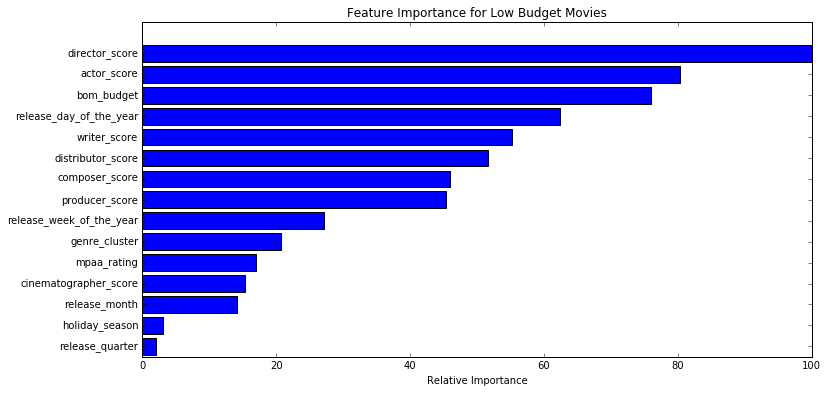

In [169]:
final_model = clf.fit(x,y)
feature_importance = clf.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance for Low Budget Movies')
plt.show()

##### Low Budget

n_estimators=100, max_depth=4,learning_rate=.1

* Root Mean squared error: 1.78
* R squared: 0.481

Feature importance (8,9,0):
 1. director_score
 2. writer_score
 3. budget
 
 
##### Mid Budget

n_estimators=200, max_depth=1,learning_rate=.1

* Root Mean squared error: 1.43
* R squared: 0.418

Feature importance (8,9,7):
 1. writer_score
 2. director_score
 3. actor_score

##### High Budget

n_estimators=200, max_depth=1,learning_rate=.1

* Root Mean squared error: 1.22
* R squared: 0.402

Feature importance (7,8,9):
 1. actor_score
 2. director_score
 3. writer_score